In [1]:
# notebooks/model_random_forest.ipynb

In [2]:
# import libraries and helper fucntions 
import sys
import os

# add project root 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, log_loss

In [3]:
# Load target label
y_train = joblib.load('../outputs/models/y_train_tfidf_balanced.joblib')  # this just loads in the tfidf ones since these are all the same

# load the balanced datasets 
X_train_tfidf = joblib.load('../outputs/models/X_train_tfidf_balanced.joblib')
X_train_bow = joblib.load('../outputs/models/X_train_bow_balanced.joblib')
X_train_spacy = joblib.load('../outputs/models/X_train_spacy_balanced.joblib')

In [21]:
# hyperparamaters for random forest 
n_estimators = 300
max_depth = 30
min_samples_leaf=5

In [22]:
# train RF with slected embedding technique funttion
def train_random_forest(X_train, y_train, model_name):
    rf = RandomForestClassifier(oob_score=True, 
                                random_state=21, 
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf)
    rf.fit(X_train, y_train)
    model_path = f'../outputs/models/{model_name}.joblib'
    joblib.dump(rf, model_path) # dump file to joblib 
    print(f'Model saved to {model_path}')

# Random Forest x TFIDF
print("Training Random Forest x TFIDF...")
train_random_forest(X_train_tfidf, y_train, 'Random_Forest_TFIDF')
print("Done!")

# Random Forest x BOW
print("Training Random Forest x BoW...")
train_random_forest(X_train_bow, y_train, 'Random_Forest_BOW')
print("Done!")

# Random Forest x spaCy
print("Training Random Forest x SpaCy...")
train_random_forest(X_train_spacy, y_train, 'Random_Forest_SPACY')
print("Done!")

Training Random Forest x TFIDF...
Model saved to ../outputs/models/Random_Forest_TFIDF.joblib
Done!
Training Random Forest x BoW...
Model saved to ../outputs/models/Random_Forest_BOW.joblib
Done!
Training Random Forest x SpaCy...
Model saved to ../outputs/models/Random_Forest_SPACY.joblib
Done!


In [24]:
# function to calculate test loss and accuracy
def calculate_test_metrics(model, X, y_true, embedding_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    accuracy = accuracy_score(y_true, y_pred)
    loss = log_loss(y_true, y_proba) # didnt actually end up using loss for this 
    print(f"Test Set ({embedding_name}) - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    return accuracy, loss

# Helper function to extract OOB metrics
def calculate_oob_metrics(model, embedding_name):
    if hasattr(model, "oob_score_"):
        oob_accuracy = model.oob_score_
        print(f"OOB ({embedding_name}) - Accuracy: {oob_accuracy:.4f}")
        return oob_accuracy
    else:
        print(f"OOB ({embedding_name}) - Not Available (ensure OOB is enabled during training)")
        return None

In [25]:
# Load the test data
y_test = joblib.load('../outputs/models/y_test.joblib')
X_test_tfidf = joblib.load('../outputs/models/X_test_tfidf.joblib')
X_test_bow = joblib.load('../outputs/models/X_test_bow.joblib')  
X_test_spacy = joblib.load('../outputs/models/X_test_spacy.joblib') 

# load in trained RF models
rf_tfidf = joblib.load('../outputs/models/Random_Forest_TFIDF.joblib')
rf_bow = joblib.load('../outputs/models/Random_Forest_BOW.joblib')
rf_spacy = joblib.load('../outputs/models/Random_Forest_SPACY.joblib')

# calculate OOB and test acc  + test loss
oob_accuracies = []
test_accuracies = []
test_losses = []

for model, X_test, embedding_name in zip(
    [rf_tfidf, rf_bow, rf_spacy],
    [X_test_tfidf, X_test_bow, X_test_spacy],
    ["TFIDF", "BoW", "SpaCy"]
):
    #  OOB accuracy
    oob_accuracy = calculate_oob_metrics(model, embedding_name)
    oob_accuracies.append(oob_accuracy)
    
    #  test set metrics
    test_accuracy, test_loss = calculate_test_metrics(model, X_test, y_test, embedding_name)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

# organize the metrics for plotting
metrics_data = {
    'embeddings': ['TFIDF', 'BOW', 'SpaCy'],
    'oob_accuracies': oob_accuracies,
    'test_accuracies': test_accuracies,
    'test_losses': test_losses
}

# print final metrics 
print("\nMetrics Summary:")
for i, embedding in enumerate(metrics_data['embeddings']):
    print(f"\nEmbedding: {embedding}")
    print(f"  OOB Accuracy: {metrics_data['oob_accuracies'][i]}")
    print(f"  Test Accuracy: {metrics_data['test_accuracies'][i]}")
    print(f"  Test Loss: {metrics_data['test_losses'][i]}")

print("\nMetrics saved successfully.")


OOB (TFIDF) - Accuracy: 0.8101
Test Set (TFIDF) - Accuracy: 0.5484, Loss: 1.1704
OOB (BoW) - Accuracy: 0.6137
Test Set (BoW) - Accuracy: 0.5423, Loss: 1.1894
OOB (SpaCy) - Accuracy: 0.8242
Test Set (SpaCy) - Accuracy: 0.5221, Loss: 1.1559

Metrics Summary:

Embedding: TFIDF
  OOB Accuracy: 0.8101063095402458
  Test Accuracy: 0.548426445474506
  Test Loss: 1.17042545947409

Embedding: BOW
  OOB Accuracy: 0.613723595195361
  Test Accuracy: 0.5423273969260796
  Test Loss: 1.1894394317677797

Embedding: SpaCy
  OOB Accuracy: 0.824216484881955
  Test Accuracy: 0.5220785557453037
  Test Loss: 1.1559066986629185

Metrics saved successfully.


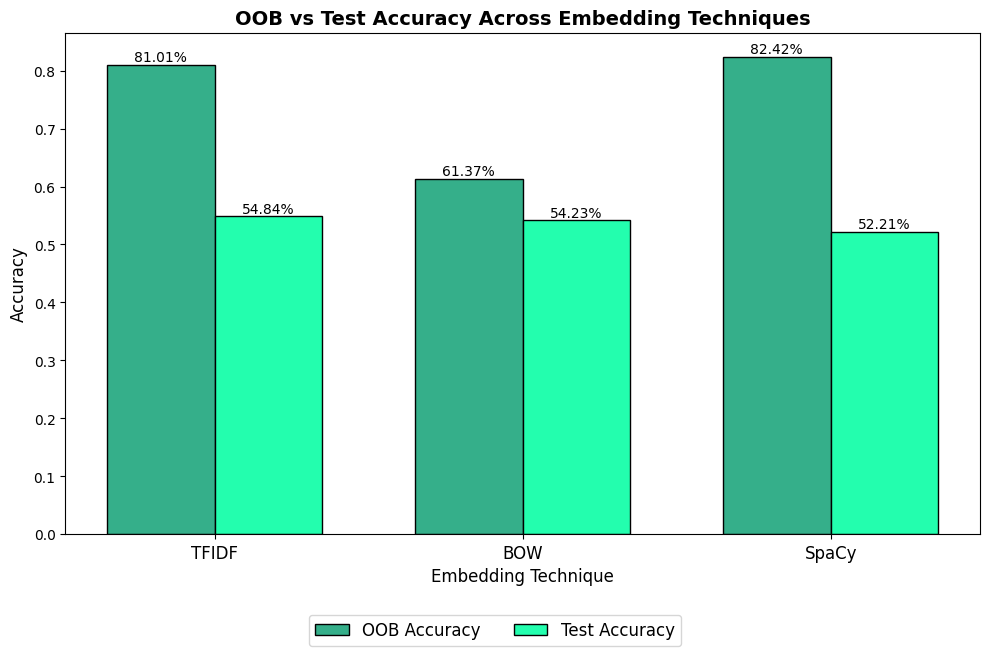

In [ ]:
# Custom color palette
custom_palette = [
    '#1E4436',  # Dark green
    '#35AF8A',  # Mid green
    '#23FEAE',  # Bright green
]

# Data for OOB and Test Set metrics (already done in metrics_data)
embeddings = metrics_data['embeddings']
oob_accuracies = metrics_data['oob_accuracies']  # OOB accuracies
test_accuracies = metrics_data['test_accuracies']  # test accuracies

# chart configs
x = np.arange(len(embeddings))  # The label locations
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))

# plot accuracy on a bar chart
bars1 = ax.bar(x - width/2, oob_accuracies, width, label='OOB Accuracy', color=custom_palette[1], edgecolor='black')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color=custom_palette[2], edgecolor='black')
ax.set_xlabel('Embedding Technique', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(embeddings, fontsize=12)
ax.set_title('OOB vs Test Accuracy Across Embedding Techniques', fontsize=14, fontweight='bold')

# Add percentage labels on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom', fontsize=10)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), fontsize=12)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # legend below plot space
plt.show()


In [27]:
# Random Forest x TFIDF
joblib.dump(rf_tfidf, '../outputs/models/Random_Forest_TFIDF.joblib')

# Random Forest x BOW
joblib.dump(rf_bow, '../outputs/models/Random_Forest_BOW.joblib')

# Random Forest x spaCy
joblib.dump(rf_spacy, '../outputs/models/Random_Forest_SPACY.joblib')

['../outputs/models/Random_Forest_SPACY.joblib']